In [1]:
#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import random
import pandas as pd
from PIL import Image

# Directory where images and .txt files are stored
image_dir = "/kaggle/input/cocotext-v20/data"

entries = []

# Get all .txt annotation files
all_txts = [f for f in os.listdir(image_dir) if f.endswith(".txt")]

# Sample only 500 files
sampled_txts = random.sample(all_txts, min(500, len(all_txts)))

for txt_file in sampled_txts:
    txt_path = os.path.join(image_dir, txt_file)
    img_filename = txt_file.replace(".txt", ".jpg")
    img_path = os.path.join(image_dir, img_filename)

    # Make sure the image exists
    if not os.path.exists(img_path):
        continue

    # Get image dimensions dynamically
    with Image.open(img_path) as img:
        img_width, img_height = img.size

    with open(txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id, x_center, y_center, w, h = map(float, parts)

            # Convert from normalized to absolute coordinates
            x_center *= img_width
            y_center *= img_height
            w *= img_width
            h *= img_height

            x_min = int(x_center - w / 2)
            y_min = int(y_center - h / 2)

            entries.append({
                'image_path': img_path,
                'bbox': [x_min, y_min, int(w), int(h)],
                'text': '[UNKNOWN]',  # Placeholder since YOLO doesn't include text
                'source': 'COCO-Text (sample)'
            })

# Create DataFrame
df = pd.DataFrame(entries)

# Save to CSV
df.to_csv("sampled_coco_text_yolo.csv", index=False)
print(f"✅ Saved {len(df)} entries from {len(sampled_txts)} sampled files.")


✅ Saved 2406 entries from 500 sampled files.


In [3]:
import os
import json
import random
import pandas as pd
from PIL import Image

# === Path Setup ===
json_path = "/kaggle/input/textocr-text-extraction-from-images-dataset/TextOCR_0.1_train.json"
image_dir = "/kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images/train_images"

# === Load JSON
with open(json_path, 'r') as f:
    data = json.load(f)

# === image_id → filename map
image_map = {img_id: img_data["file_name"] for img_id, img_data in data["imgs"].items()}

# === Filter valid annotations
valid_anns = [
    ann for ann in data["anns"].values()
    if ann.get("utf8_string", "").strip() not in ["", ".", "..", "..."]
]

print(f"🔎 Found {len(valid_anns)} valid annotations with useful text.")

# === Sample
sampled_anns = random.sample(valid_anns, min(500, len(valid_anns)))

entries = []

for ann in sampled_anns:
    image_id = str(ann["image_id"])
    if image_id not in image_map:
        continue

    text = ann.get('utf8_string', '').strip()

    # 🔧 Strip 'train/' from filename to match actual folder structure
    img_filename = image_map[image_id].replace("train/", "")
    img_path = os.path.join(image_dir, img_filename)

    if not os.path.exists(img_path):
        print(f"⚠️ Missing image: {img_path}")
        continue

    try:
        with Image.open(img_path) as img:
            img_width, img_height = img.size
    except Exception as e:
        print(f"⚠️ Error reading image {img_path}: {e}")
        continue

    x, y, w, h = ann['bbox']
    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)

    entries.append({
        'image_path': img_path,
        'bbox': [x, y, w, h],
        'text': text,
        'source': 'TextOCR (sample)'
    })

# === Save
if not entries:
    print("❌ No valid entries found after filtering and path resolution.")
else:
    df = pd.DataFrame(entries)
    df['clean_text'] = df['text'].apply(lambda t: t.lower().strip())
    df.to_csv("sampled_textocr.csv", index=False)
    print(f"✅ Saved {len(df)} clean TextOCR entries to 'sampled_textocr.csv'.")



🔎 Found 714770 valid annotations with useful text.
✅ Saved 500 clean TextOCR entries to 'sampled_textocr.csv'.


In [4]:
import pandas as pd

# Load both datasets
coco_df = pd.read_csv("sampled_coco_text_yolo.csv")
textocr_df = pd.read_csv("sampled_textocr.csv")

# Optional: fill missing clean_text in COCO if needed
if 'clean_text' not in coco_df.columns:
    coco_df['clean_text'] = coco_df['text'].apply(lambda t: str(t).lower().strip())

# Concatenate
merged_df = pd.concat([coco_df, textocr_df], ignore_index=True)

# Shuffle rows
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save final merged dataset
merged_df.to_csv("merged_ocr_dataset.csv", index=False)
print(f"✅ Merged dataset saved as 'merged_ocr_dataset.csv' with {len(merged_df)} rows.")


✅ Merged dataset saved as 'merged_ocr_dataset.csv' with 2906 rows.


In [5]:
import pandas as pd
import cv2
import os

df = pd.read_csv("merged_ocr_dataset.csv")

# Function to crop text regions from images
def crop_text_region(row):
    image_path = row['image_path']
    x, y, w, h = eval(row['bbox'])  # or use literal_eval if safer
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        crop = img[y:y+h, x:x+w]
        return crop
    except:
        return None


In [6]:
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import torch

class TextOCRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x, y, w, h = eval(row['bbox'])
        image = cv2.imread(row['image_path'])
        if image is None:
            return None

        crop = image[y:y+h, x:x+w]
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(crop)

        if self.transform:
            pil_img = self.transform(pil_img)

        text = row['clean_text']
        return pil_img, text


In [7]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("/kaggle/input/microsoft-trocr/trocr-base-printed/processor")
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/microsoft-trocr/trocr-base-printed/model")



2025-05-25 16:13:43.119446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748189623.421797      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748189623.502941      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder c

In [8]:
class TextOCRDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, processor, max_target_length=64):
        self.df = dataframe
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        x, y, w, h = eval(row['bbox'])
        text = row['clean_text']

        # Load and crop
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image[y:y+h, x:x+w], cv2.COLOR_BGR2RGB)

        # Process
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()
        labels = self.processor.tokenizer(text, padding="max_length",
                                          max_length=self.max_target_length,
                                          truncation=True,
                                          return_tensors="pt").input_ids.squeeze()

        return {
            "pixel_values": pixel_values,
            "labels": labels
        }



✅ Ground Truth: of
🔮 Predicted: OF


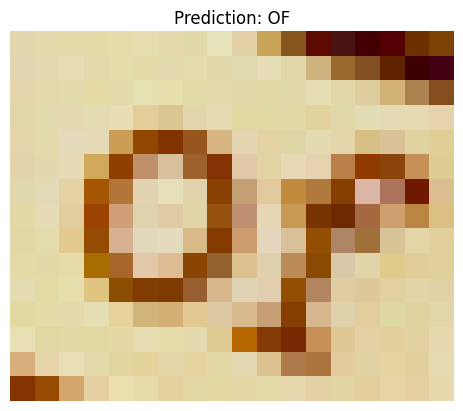


✅ Ground Truth: o'brien
🔮 Predicted: O'BRIEN


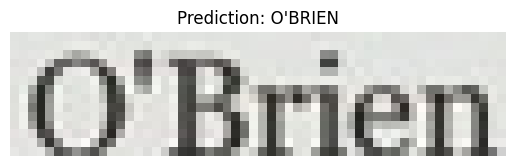


✅ Ground Truth: mile
🔮 Predicted: MICE


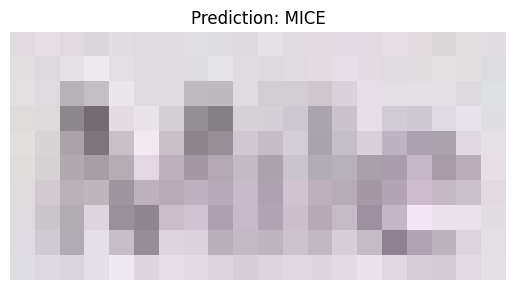


✅ Ground Truth: vb.
🔮 Predicted: 78


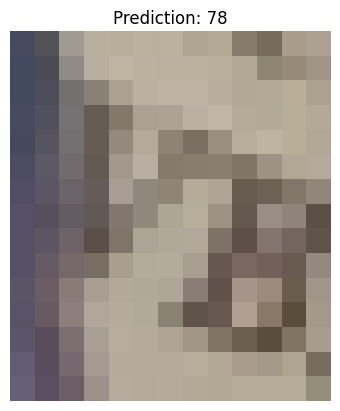


✅ Ground Truth: all
🔮 Predicted: 8.00


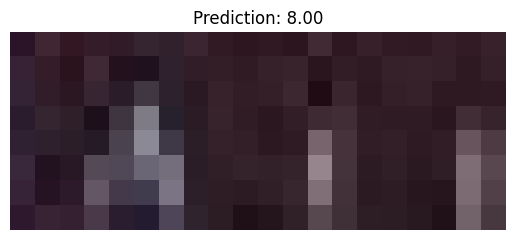

In [9]:
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import ast



# Load dataset
df = pd.read_csv("sampled_textocr.csv")

# Preview first 5 samples
samples = df.head(5)

true_texts = []
pred_texts = []

for idx, row in samples.iterrows():
    image_path = row['image_path']
    bbox = ast.literal_eval(row['bbox'])  # Convert string to list
    x, y, w, h = map(int, bbox)
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Failed to load {image_path}")
        continue
    crop = image[y:y+h, x:x+w]
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

    pil_img = Image.fromarray(crop)
    inputs = processor(images=pil_img, return_tensors="pt").pixel_values
    with torch.no_grad():
        output_ids = model.generate(inputs)[0]
    pred_text = processor.tokenizer.decode(output_ids, skip_special_tokens=True).strip()
    true_text = str(row['clean_text']).strip()

    # Store for evaluation
    pred_texts.append(pred_text)
    true_texts.append(true_text)

    # Show result
    print(f"\n✅ Ground Truth: {true_text}")
    print(f"🔮 Predicted: {pred_text}")
    
    plt.imshow(pil_img)
    plt.axis("off")
    plt.title(f"Prediction: {pred_text}")
    plt.show()


In [10]:
import numpy as np

# Exact match
def compute_accuracy(true_list, pred_list):
    return np.mean([t.strip().lower() == p.strip().lower() for t, p in zip(true_list, pred_list)])

# CER (Levenshtein distance / total characters)
def compute_cer(true_list, pred_list):
    total_dist = 0
    total_chars = 0
    for ref, hyp in zip(true_list, pred_list):
        ref = ref.strip().lower()
        hyp = hyp.strip().lower()
        total_dist += levenshtein(ref, hyp)
        total_chars += len(ref)
    return total_dist / max(total_chars, 1)

# WER (word-level Levenshtein distance)
def compute_wer(true_list, pred_list):
    total_dist = 0
    total_words = 0
    for ref, hyp in zip(true_list, pred_list):
        ref_words = ref.strip().lower().split()
        hyp_words = hyp.strip().lower().split()
        total_dist += levenshtein(ref_words, hyp_words)
        total_words += len(ref_words)
    return total_dist / max(total_words, 1)

# Levenshtein distance (basic implementation)
def levenshtein(a, b):
    if isinstance(a, list):
        a = ' '.join(a)
    if isinstance(b, list):
        b = ' '.join(b)
    m, n = len(a), len(b)
    dp = np.zeros((m+1, n+1), dtype=int)
    for i in range(m+1): dp[i][0] = i
    for j in range(n+1): dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            dp[i][j] = min(
                dp[i-1][j] + 1,
                dp[i][j-1] + 1,
                dp[i-1][j-1] + (a[i-1] != b[j-1])
            )
    return dp[m][n]


In [11]:
# After collecting predictions
acc = compute_accuracy(true_texts, pred_texts)
cer = compute_cer(true_texts, pred_texts)
wer = compute_wer(true_texts, pred_texts)

print("\n📊 Evaluation Results:")
print(f"✅ Exact Match Accuracy: {acc:.2%}")
print(f"✏️  Character Error Rate (CER): {cer:.4f}")
print(f"📢 Word Error Rate (WER): {wer:.4f}")



📊 Evaluation Results:
✅ Exact Match Accuracy: 40.00%
✏️  Character Error Rate (CER): 0.4211
📢 Word Error Rate (WER): 1.6000


In [12]:
import pandas as pd
import ast
import torch
from datasets import Dataset
from PIL import Image
import cv2
from transformers import TrOCRProcessor

# Load your dataset
df = pd.read_csv("sampled_textocr.csv")
df = df.dropna(subset=["image_path", "bbox", "clean_text"])
df["clean_text"] = df["clean_text"].str.lower().str.strip()



# Load processor
processor = TrOCRProcessor.from_pretrained("/kaggle/input/microsoft-trocr/trocr-base-printed/processor")

# Define image + label mapping
def preprocess(example):
    x, y, w, h = ast.literal_eval(example["bbox"])
    image = cv2.imread(example["image_path"])
    crop = image[y:y+h, x:x+w]
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(crop)

    pixel_values = processor(images=pil_img, return_tensors="pt").pixel_values[0]  # Fix is here ✅
    labels = processor.tokenizer(example["clean_text"],
                                 padding="max_length",
                                 max_length=64,
                                 truncation=True,
                                 return_tensors="pt").input_ids[0]                 # And here ✅
    labels[labels == processor.tokenizer.pad_token_id] = -100

    return {
        "pixel_values": pixel_values,
        "labels": labels
    }

# Convert to HF dataset
hf_dataset = Dataset.from_pandas(df)
hf_dataset = hf_dataset.map(preprocess)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

The channel dimension is ambiguous. Got image shape (3, 3, 3). Assuming channels are the first dimension.


In [ ]:
import os
from transformers import Trainer, TrainingArguments

os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./trocr-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=100,
    save_total_limit=1,
    remove_unused_columns=False,
    fp16=True,
)

def trocr_data_collator(batch):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) if isinstance(example["pixel_values"], list) else example["pixel_values"] for example in batch])
    labels = torch.stack([torch.tensor(example["labels"]) if isinstance(example["labels"], list) else example["labels"] for example in batch])
    return {"pixel_values": pixel_values, "labels": labels}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset,
    eval_dataset=hf_dataset.select(range(50)),
    tokenizer=processor.tokenizer,
    data_collator=trocr_data_collator,
)

# 🔧 Required for training
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id


trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,4.238600
20,3.427000
30,3.342200
40,2.951100
50,2.916900
60,2.809000
70,2.776500
80,2.550000
90,3.025900
100,2.642600


In [ ]:
true_texts = []
pred_texts = []

df = pd.read_csv("sampled_textocr.csv").dropna(subset=["image_path", "bbox", "clean_text"])
samples = df.sample(50, random_state=42)

for _, row in samples.iterrows():
    image_path = row['image_path']
    bbox = ast.literal_eval(row['bbox'])
    x, y, w, h = map(int, bbox)

    image = cv2.imread(image_path)
    if image is None:
        continue
    crop = image[y:y+h, x:x+w]
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(crop)

    pixel_values = processor(images=pil_img, return_tensors="pt").pixel_values
    with torch.no_grad():
        output_ids = model.generate(pixel_values)
    pred = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    true_texts.append(row['clean_text'].strip())
    pred_texts.append(pred)

# Now evaluate
acc = compute_accuracy(true_texts, pred_texts)
cer = compute_cer(true_texts, pred_texts)
wer = compute_wer(true_texts, pred_texts)

print("\n📊 Evaluation Results:")
print(f"✅ Accuracy: {acc:.2%}")
print(f"✏️ CER     : {cer:.4f}")
print(f"📢 WER     : {wer:.4f}")


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    MarianMTModel,
    MarianTokenizer
)

# ✅ Load models
ocr_model = VisionEncoderDecoderModel.from_pretrained("./trocr-finetuned")
ocr_processor = TrOCRProcessor.from_pretrained("/kaggle/input/microsoft-trocr/trocr-base-printed/processor")
ocr_model.eval()

translator_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ar")
translator_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-ar")

def translate_batch(texts):
    inputs = translator_tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    translated_ids = translator_model.generate(**inputs)
    return [translator_tokenizer.decode(t, skip_special_tokens=True) for t in translated_ids]

def overlay_text(img, text, x, y):
    font = cv2.FONT_HERSHEY_SIMPLEX
    return cv2.putText(img, text, (x, y), font, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

# ✅ Load your dataset
df = pd.read_csv("sampled_textocr.csv").dropna(subset=["image_path", "bbox", "clean_text"])

# ✅ Pick one image that has multiple boxes
sample_image_path = df.sample(1)["image_path"].values[0]
group = df[df["image_path"] == sample_image_path].reset_index(drop=True)

# ✅ Load the image
image = cv2.imread(sample_image_path)
if image is None:
    raise ValueError(f"Image not found: {sample_image_path}")

ocr_texts = []
coords = []

# ✅ Run OCR on each box
for _, row in group.iterrows():
    x, y, w, h = map(int, ast.literal_eval(row["bbox"]))
    crop = image[y:y+h, x:x+w]
    if crop.size == 0:
        continue
    pil_crop = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    
    pixel_values = ocr_processor(images=pil_crop, return_tensors="pt").pixel_values
    with torch.no_grad():
        generated_ids = ocr_model.generate(pixel_values)
    ocr_text = ocr_processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()
    
    ocr_texts.append(ocr_text)
    coords.append((x, y))

# ✅ Translate all OCR results
translated_texts = translate_batch(ocr_texts)

# ✅ Overlay all translated texts
image_with_text = image.copy()
for text, (x, y) in zip(translated_texts, coords):
    image_with_text = overlay_text(image_with_text, text, x, y - 10)

# ✅ Show result
print("📝 OCR texts:\n", ocr_texts)
print("🌍 Translated:\n", translated_texts)
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_with_text, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Batch Translation Overlay")
plt.show()
